In [1]:
!pip3 install http://download.pytorch.org/whl/cu90/torch-0.3.0-cp36-cp36m-linux_x86_64.whl

    83% |██████████████████████████▋     | 526.8MB 48.2MB/s eta 0:00:03

    100% |████████████████████████████████| 632.9MB 14.3MB/s 


In [0]:
import torch as T
from torch import nn
import torch.nn.functional as F
from __future__ import unicode_literals,print_function,division
from io import open
import unicodedata
import string
import re
import random
from torch.autograd import Variable
from torch import optim
from torch.nn import Parameter
import math

In [4]:
use_cuda = T.cuda.is_available()
# use_cuda=False
print(use_cuda)

True


In [55]:
!wget https://download.pytorch.org/tutorial/data.zip;unzip data.zip

--2018-04-08 02:52:58--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 52.85.35.222, 52.85.35.58, 52.85.35.24, ...
Connecting to download.pytorch.org (download.pytorch.org)|52.85.35.222|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  3.83MB/s    in 0.7s    

2018-04-08 02:52:59 (3.83 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.

In [0]:
SOS_TOKEN = 0 
EOS_TOKEN = 1
class Lang:
  def __init__(self,name):
    self.name = name
    self.word2index = {}
    self.word2count = {}
    self.index2word = {'0':"SOS",1:"EOS"}
    self.n_words = 2
  def addSentence(self,sentence):
    for word in sentence.split(" "):
      self.addWord(word)
  
  def addWord(self,word):
    if word not in self.word2index:
      self.word2index[word] = self.n_words
      self.word2count[word] = 1
      self.index2word[self.n_words] = word
      self.n_words += 1
    else:
      self.word2count[word] += 1

      
def unicode2ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD',s) if unicodedata.category(c) !='Mn')

def normalizeString(s):
  s = unicode2ascii(s.lower().strip())
  s = re.sub(r"([.!?])",r"\1",s)
  s = re.sub(r"[^a-zA-Z.!?]+",r" ",s)
  return s

In [0]:
def readLangs(lang1,lang2,reverse = False):
  print("Reading lines...")
  lines = open('data/%s-%s.txt'%(lang1,lang2),encoding="utf8").read().strip().split('\n')
  pairs = [[normalizeString(s) for s in l.split("\t")] for l in lines]
  if reverse:
    pairs = [list(reversed(p)) for p in pairs]
    input_lang = Lang(lang2)
    output_lang = Lang(lang1)
  else:
    input_lang = Lang(lang2)
    output_lang = Lang(lang1)
  return input_lang,output_lang,pairs

In [0]:
MAX_LENGTH = 10
eng_prefixs = (
        "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixs)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [8]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 11739 sentence pairs
Counting words...
Counted words:
fra 5911
eng 3965
['je suis desole si je t ai derangee.', 'i m sorry if i disturbed you.']


In [0]:
class IndRNNCell(nn.Module):
  
  def __init__(self,input_size,hidden_size,bias=True, nonlinearity='relu', hidden_min_abs = 0, hidden_max_abs = None):
    super(IndRNNCell,self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.nonlinearity = nonlinearity
    self.hidden_min_abs = hidden_min_abs
    self.hidden_max_abs = hidden_max_abs
    self.bias = bias 
    self.weight_ih = Parameter(T.Tensor(hidden_size,input_size))
    self.weight_hh = Parameter(T.Tensor(hidden_size))
    
    if bias :
      self.bias_ih = Parameter(T.Tensor(hidden_size))
     
    else:
      self.register_parameter('bias_ih',None)
    
    self.reset_parameters()
  
  def reset_parameters(self):
    stdv = 1.0 / math.sqrt(self.hidden_size)
    
    for name,weight in self.named_parameters():
      if 'bias' in name:
        weight.data.zero_()
      elif "weight_hh" in name:
        if self.hidden_max_abs:
          stdv_ = self.hidden_max_size
        else:
          stdv_ = stdv
        
        weight.data.uniform_(-stdv_,stdv_)
      elif "weight_ih" in name:
        weight.data.normal_(0,0.01)
      else:
        weight.data.normal_(0,0.01)
    
    self.check_bounds()
  
  def check_bounds(self):
    
    if self.hidden_min_abs:
      abs_kernel = T.abs(self.weight_hh.data)
      min_abs_kernel = T.clamp(abs_kernel,min=self.hidden_min_abs)
      
      self.weight_hh.data.copy_(
        T.mul(T.sign(self.weight_hh.data),min_abs_kernel)
      )
      
    if self.hidden_max_abs:
      
      self.weight_hh.data.copy_(
          T.clamp(self.weight_hh.data,max=self.hidden_max_abs,min=-self.hidden_max_abs)
      )      
  
  def IndRNNTanhCell(self,input,hidden,w_ih,w_hh,b_ih=None):
    hy = F.tanh(F.linear(input,w_ih,b_ih) + F.mul(w_hh,hidden))
    return hy
  def IndRNNReluCell(self,input,hidden,w_ih,w_hh,b_ih=None):
    hy = F.relu(F.linear(input,w_ih,b_ih) + F.mul(w_hh,hidden))
    return hy
  def forward(self,input,hx):
    if self.nonlinearity =='tanh':
      func = self.IndRNNTanhCell
    elif self.nonlinearity =='relu':
      func = self.IndRNNReluCell
      
    return func(input,hx,self.weight_ih,self.weight_hh,self.bias_ih)
  
class IndRNN(nn.Module):
  
    def __init__(self, input_size, hidden_size, n_layer=1, batch_norm=False,
                 step_size=None, **kwargs):
        super(IndRNN, self).__init__()
        self.hidden_size = hidden_size
        if batch_norm and step_size is None:
            raise Exception("Frame wise batch size needs to know the step size")
        self.batch_norm = batch_norm
        self.step_size = step_size
        self.n_layer = n_layer

        cells = []
        for i in range(n_layer):
            if i == 0:
                cells += [IndRNNCell(input_size, hidden_size, **kwargs)]
            else:
                cells += [IndRNNCell(hidden_size, hidden_size, **kwargs)]
        self.cells = nn.ModuleList(cells)

        if batch_norm:
            bns = []
            for i in range(n_layer):
                bns += [nn.BatchNorm2d(step_size)]
            self.bns = nn.ModuleList(bns)
            
        
        h0 = T.zeros(hidden_size)
        self.register_buffer('h0', T.autograd.Variable(h0))


    def forward(self, x, hidden=None):                
        for i, cell in enumerate(self.cells):
            cell.check_bounds()
            hx = self.h0.unsqueeze(0).expand(x.size(0), self.hidden_size).contiguous()
            outputs = []
            for t in range(x.size(1)):
                x_t = x[:, t]
                hx = cell(x_t, hx)
                outputs += [hx]
            x = T.stack(outputs, 1)
            if self.batch_norm:
                x = self.bns[i](x)
        return x.squeeze(2)

In [0]:
rnn = IndRNN(10,20,2)
input = Variable(T.randn(5,3,10))
h0 = Variable(T.randn(2,3,20))

output = rnn(input,h0)

print(output)

In [0]:
class RNNencoder(nn.Module):
  def __init__(self,input_size,hidden_size):
    super(RNNencoder,self).__init__()
    self.hidden_size = hidden_size
    self.embedding = nn.Embedding(input_size,hidden_size)
    self.gru = IndRNN(self.hidden_size,self.hidden_size)
    
  def forward(self,input,hidden):
    embed = self.embedding(input).view(1,1,-1)
    output = embed
    
    output = self.gru(output,hidden)
    return output
  def init_hidden(self):
    result = Variable(T.zeros(1,1,self.hidden_size))
    if use_cuda:
      return result.cuda()
    else:
      return result

In [0]:
class AttenDecoderRNN(nn.Module):
  def __init__(self,hidden_size,output_size,dropout = 0.1,max_length = MAX_LENGTH):
    super(AttenDecoderRNN,self).__init__()
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.dropout = dropout
    self.max_length = max_length
    
    self.embed = nn.Embedding(self.output_size,self.hidden_size)
    self.atten = nn.Linear(self.hidden_size * 2 ,self.max_length)
    self.atten_combine = nn.Linear(self.hidden_size*2,self.hidden_size)
    self.drop = nn.Dropout(self.dropout)
    self.gru = nn.GRU(self.hidden_size,self.hidden_size)
    self.out = nn.Linear(self.hidden_size,self.output_size)
  def forward(self,input,hidden,encoder_outputs):
    embed = self.embed(input).view(1,1,-1)
    embed = self.drop(embed)
    atten_weights = F.softmax(
      self.atten(T.cat((embed[0],hidden[0]),-1)),dim=1
    )
    atten_applied = T.bmm(atten_weights.unsqueeze(0),encoder_outputs.unsqueeze(0))
    
    output = T.cat((embed[0],atten_applied[0]),1)
    output = self.atten_combine(output).unsqueeze(0)
    
    outout = F.relu(output)
    
    output,hidden = self.gru(output,hidden)
    output = F.log_softmax(self.out(output[0]),dim=1)
    
    return output,hidden,atten_weights
  def init_hidden(self):
    if use_cuda:
      return Variable(T.zeros(1,1,self.hidden_size)).cuda()
    else:return Variable(T.zeros(1,1,self.hidden_size))

In [0]:
def indexesfromsentence(lang,sentence):
#   print(lang.word2index)
  return [lang.word2index[word] for word in sentence.split(" ")]

def variablefromsentence(lang,sentence):
  indexes = indexesfromsentence(lang,sentence)
  indexes.append(EOS_TOKEN)
  result = Variable(T.LongTensor(indexes).view(-1,1))
  if use_cuda:
    return result.cuda()
  else:return result

def variablefrompair(pair):
  input_variable = variablefromsentence(input_lang,pair[0])
  target_variable = variablefromsentence(output_lang,pair[1])
  return (input_variable,target_variable)



In [0]:
teacher_forcing_ratio = 0.5

def train(input_variable,target_variable,encode,decode,encode_optimizer,decode_optimizer,criterion,max_length=MAX_LENGTH):
  encode_hidden = encode.init_hidden()
  encode_optimizer.zero_grad()
  decode_optimizer.zero_grad()
  input_length = input_variable.size()[0]
  target_length = target_variable.size()[0]
  encode_outputs = Variable(T.zeros(max_length,encode.hidden_size))
  encode_outputs = encode_outputs.cuda() if use_cuda else encode_outputs
  
  loss = 0
  
  for ei in range(input_length):
    encode_output = encode(input_variable[ei],encode_hidden)
#     print(encode_output)
    encode_outputs[ei] = encode_output[0][0]
  
  decode_input = Variable(T.LongTensor([[SOS_TOKEN]]))
  decode_input = decode_input.cuda() if use_cuda else decode_input
  
  decode_hidden = decode.init_hidden()
  
  use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
  
  
  if use_teacher_forcing:
    for di in range(target_length):
      decode_output,decode_hidden,decode_attention = decode(decode_input,decode_hidden,encode_outputs)
#       print(decode_output[0].size())
#       print(target_variable[di].size())
      
      loss += criterion(decode_output,target_variable[di])
      
  else:
    for di in range(target_length):
      decode_output,decode_hidden,decode_attention = decode(decode_input,decode_hidden,encode_outputs)
      
      topv,topi = decode_output.data.topk(1)
      ni = topi[0][0]
      
      decode_input = Variable(T.LongTensor([[ni]]))
      decode_input = decode_input.cuda() if use_cuda else decode_input
      
      loss += criterion(decode_output,target_variable[di])
      
      if ni == EOS_TOKEN:
        break
  loss.backward()
  encode_optimizer.step()
  decode_optimizer.step()
  return loss.data[0] / target_length


  
  
  
  
  
  

In [0]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [0]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [variablefrompair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]

        loss = train(input_variable, target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [0]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    input_variable = variablefrompair(input_lang, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],
                                                 encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))  # SOS
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        decoder_attentions[di] = decoder_attention.data
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])

        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    return decoded_words, decoder_attentions[:di + 1]

In [0]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greately increasing memory usage. To compact weights again call flatten_parameters().


4m 37s (- 64m 40s) (5000 6%) 3.3563
9m 5s (- 59m 7s) (10000 13%) 3.0449
13m 40s (- 54m 42s) (15000 20%) 2.8377
18m 19s (- 50m 23s) (20000 26%) 2.7403
22m 42s (- 45m 25s) (25000 33%) 3.4349
27m 11s (- 40m 46s) (30000 40%) 3.6851
31m 40s (- 36m 12s) (35000 46%) 3.4347
36m 6s (- 31m 35s) (40000 53%) 3.3165
40m 31s (- 27m 0s) (45000 60%) 3.3073
44m 54s (- 22m 27s) (50000 66%) 3.2789
49m 19s (- 17m 56s) (55000 73%) 3.2143
53m 44s (- 13m 26s) (60000 80%) 3.1343
58m 11s (- 8m 57s) (65000 86%) 3.1213
62m 37s (- 4m 28s) (70000 93%) 3.0874
67m 6s (- 0m 0s) (75000 100%) 3.0742


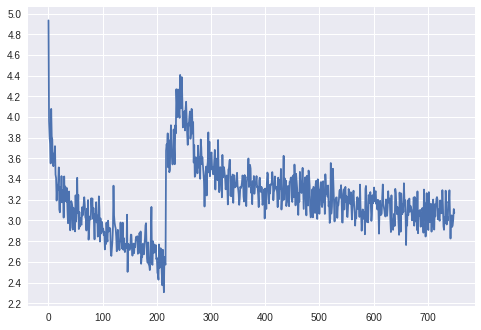

In [23]:
hidden_size = 256
encoder1 = RNNencoder(input_lang.n_words, hidden_size)
attn_decoder1 = AttenDecoderRNN(hidden_size, output_lang.n_words, dropout=0.1)


if use_cuda:
    encoder1 = encoder1.cuda()
    attn_decoder1 = attn_decoder1.cuda()

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)